<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_5_S6_waveforms.ipynb"><< Sentinel-6 waveforms</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_7_S6_SWH.ipynb">Sentinel-6 significant wave height >></a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT), Vinca Rosmorduc (CLS)

<div class="alert alert-block alert-success">
<h3>Learn Sentinel-6: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>

The following modules are prerequisites for this notebook:
- **<a href="1_1a_S6_data_access_SFTP.ipynb" target="_blank">1_1a_S6_data_access_SFTP</a>**; this will download the required Sentinel-6 products for this notebook.
- **<a href="1_4_S6_tracks.ipynb" target="_blank">1_4_S6_tracks.ipynb</a>**; to familiarise yourself with the track for the initial plots of this data.
</div>
<hr>


# 1.6 Sentinel-6 sea surface height anomalies


### Data used

| Product Description  | Data Store collection ID| Product Navigator | 
|:--------------------:|:-----------------------:|:-------------:|
| Sentinel-6 Poseidon-4 Altimetry level-2 High Resolution (NTC) | EO:EUM:DAT:0128 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:0128?query=Altimetry%20NTC&filter=satellite__Sentinel-6&results=20&s=advanced" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will know;
* How sea surface height anomalies can be computed from altimetry measurements.
* What SSHA can look like in a dynamic ocean region.

### Outline

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Reading Sentinel-6 level-2 SSHA data](#section1)
 1. [Computing corrected sea surface heights & anomalies](#section2)
 1. [Looking at SSHA in dynamic regions: the Drake Passage](#section3)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports
import cartopy
import cmocean
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import os
import warnings
import glob

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Reading Sentinel-6 level-2 SSHA data
[Back to top](#TOC_TOP)

</div>

For this notebook we're going to look at data from several tracks. We'll use the standard measurements file from each.

In [2]:
# selecting SAFE directories
SAFE_products = [glob.glob(os.path.join(os.getcwd(), 'products','S6A_P4_2__HR*_NT_*','*STD*.nc'))[0]]

In [3]:
# read data
ds_L2_01 = xr.open_dataset(SAFE_products[0], group='data_01')
ds_L2_01_ku = xr.open_dataset(SAFE_products[0], group='data_01/ku')

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Computing corrected sea surface heights & anomalies
[Back to top](#TOC_TOP)

</div>

The range as measured by satellite altimeters flying above the surface of the ocean, can't be used directly as a measure of the sea surface height. It is influenced by the state of the atmosphere, and this must be corrected for. The height of the sea surface at any instantaneous point relative to the satellite altimeter, is the result of a combination of various factors (tides, sea state, as well as the sea-level resulting from ocean circulation or long-term changes in ice melt etc). Thus we must also consider what it is we want to measure when we consider using measurements of sea surface height. 

```
The corrected sea surface height =
                              Altitude 
                              - range
                              - atmosphere propagation corrections (dry/wet troposphere, ionosphere electrons)
                              - tides (ocean, solid earth and pole)
                              - atmospheric loading (pressure & hf winds)
                              - sea state bias
```

then, depending on the reference you want to work with respect to, you can also remove either mean sea surface (to get sea level anomalies; SLAs) or the geoid (to get absolute dynamic topography; ADT), or nothing (to get SSH with respect to the ellipsoid).  For ADT, you can also add the mean topography instead of removing the geoid.

Below we define the variables we need to compute a corrected sea surface height and anomalies. The computation here is done with 1 Hz data with corrections dedicated to open ocean. Over coastal areas some correction fields would be different, such as the wet tropospheric correction (not from radiometer). Some corrections are only provided at 1Hz, since their resolution can't be higher, but they still must be applied for a computation at 20 Hz, though. So you have to use 20 times the 1 Hz value. 

In [4]:
# coordinates
lat = ds_L2_01['latitude']
lon = ds_L2_01['longitude']
alt = ds_L2_01['altitude']

# range
range_ku = ds_L2_01_ku['range_ocean']

#atmosphere propagation corrections
model_dry_tropo_corr = ds_L2_01['model_dry_tropo_cor_measurement_altitude'][:]
rad_wet_tropo_corr = ds_L2_01['model_wet_tropo_cor_measurement_altitude'][:]
iono_corr_alt_ku = ds_L2_01['iono_cor_alt'][:]

#tides
ocean_tide_sol = ds_L2_01['ocean_tide_sol2'][:]
solid_earth_tide = ds_L2_01['solid_earth_tide'][:]
ocean_tide_non_eq = ds_L2_01['ocean_tide_non_eq'][:]
internal_tide = ds_L2_01['internal_tide'][:]
pole_tide = ds_L2_01['pole_tide'][:]

#atmospheric loading and sea state bias
inv_bar_corr = ds_L2_01['inv_bar_cor'][:]
sea_state_bias_ku = ds_L2_01_ku['sea_state_bias'][:]

#reference surfaces
mean_sea_surface = ds_L2_01['mean_sea_surface_sol1'][:]
mean_topography = ds_L2_01['mean_dynamic_topography'] [:]
geoid = ds_L2_01['geoid'] [:]

# flags
surface_type = ds_L2_01['surface_classification_flag'][:]
range_flag = ds_L2_01_ku['range_ocean_qual'][:]

# SSHA
ssha = ds_L2_01_ku["ssha"][:]

We also need to flag any data that is not over the ocean. For this we can use the surface type flag discussed in the previous notebook.

In [5]:
# applying flags to remove non-ocean values
alt[surface_type != 0.0] = np.nan
range_ku[surface_type != 0.0] = np.nan
range_ku[range_flag != 0.0] = np.nan
iono_corr_alt_ku[surface_type != 0.0] = np.nan
model_dry_tropo_corr[surface_type != 0.0] = np.nan
rad_wet_tropo_corr[surface_type != 0.0] = np.nan
ocean_tide_sol[surface_type != 0.0] = np.nan
solid_earth_tide[surface_type != 0.0] = np.nan
pole_tide[surface_type != 0.0] = np.nan
inv_bar_corr[surface_type != 0.0] = np.nan
sea_state_bias_ku[surface_type != 0.0] = np.nan

Let's take a look at these variables used in the corrections...

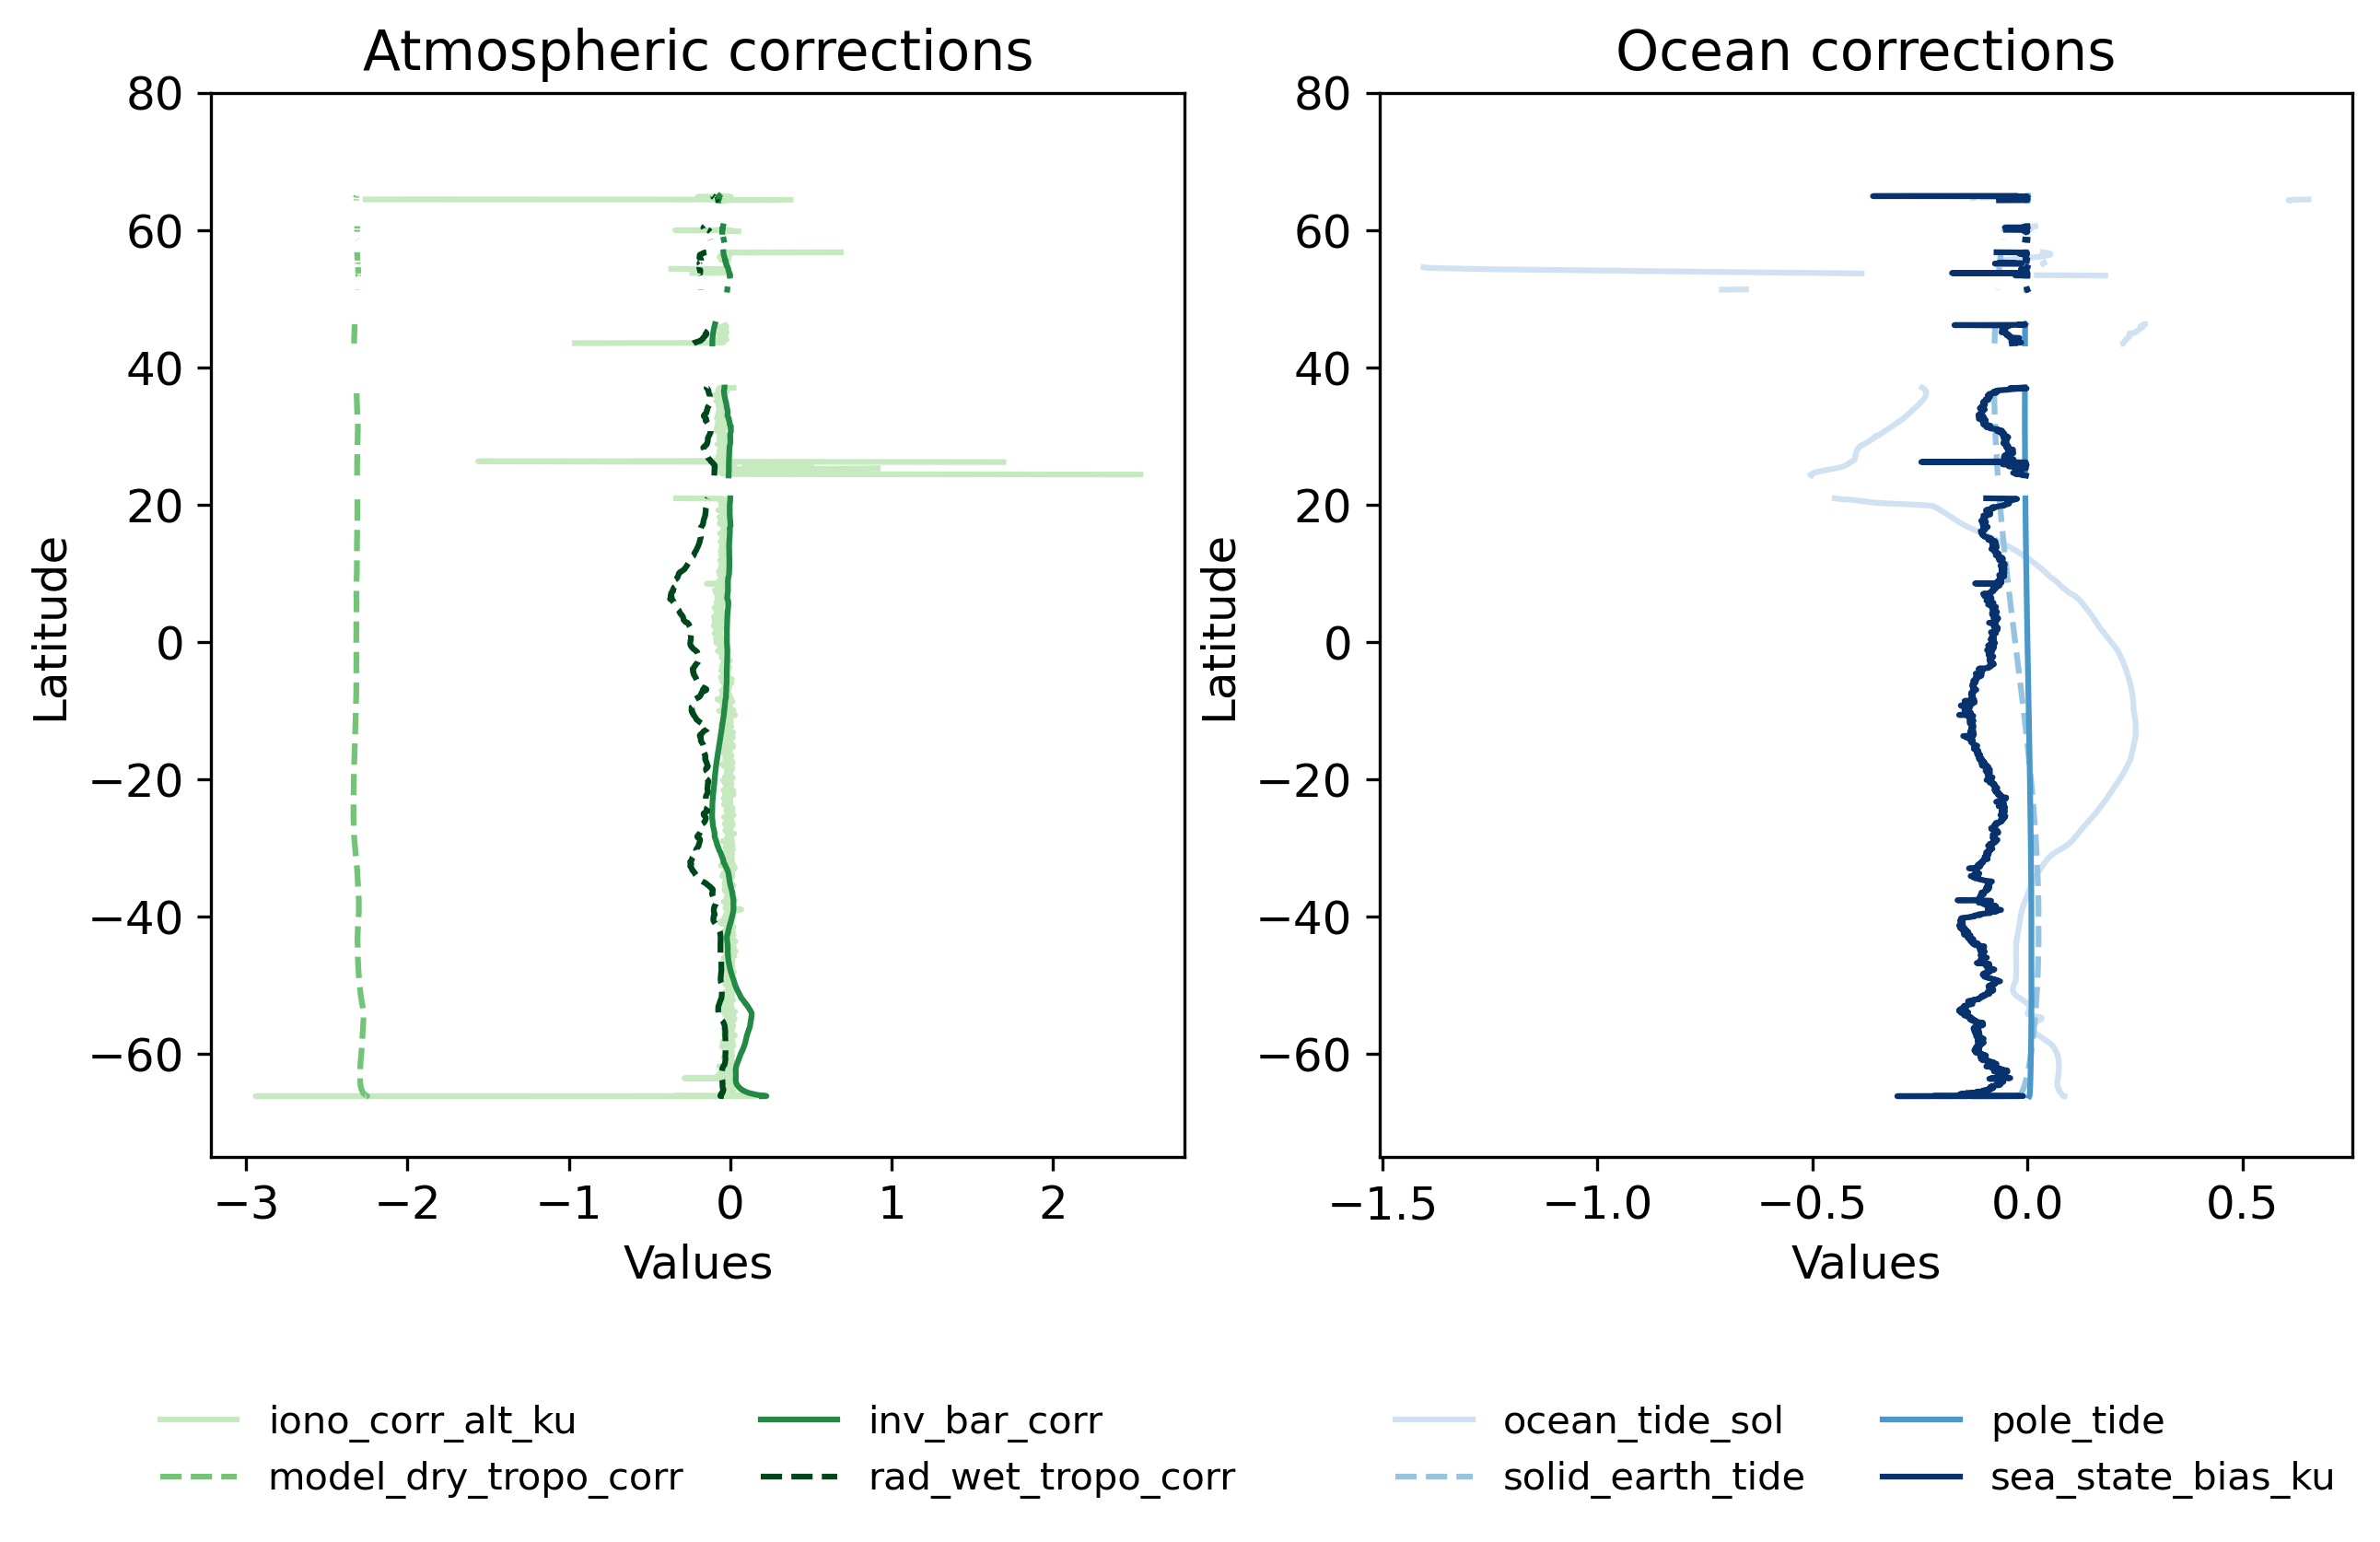

In [6]:
#visualize the variables above
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

cmap = plt.cm.Greens
p1, = axs[0].plot(iono_corr_alt_ku, lat, c=cmap(0.25), label='iono_corr_alt_ku')
p2, = axs[0].plot(model_dry_tropo_corr, lat, c=cmap(0.50), label='model_dry_tropo_corr', linestyle='--')
p3, = axs[0].plot(inv_bar_corr, lat, c=cmap(0.75), label='inv_bar_corr')
p4, = axs[0].plot(rad_wet_tropo_corr, lat, c=cmap(0.99), label='rad_wet_tropo_corr', linestyle='--')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Latitude')
axs[0].set_title("Atmospheric corrections")
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10, frameon=False)
axs[0].set_ylim([-75, 80])

cmap = plt.cm.Blues
p5, = axs[1].plot(ocean_tide_sol, lat, c=cmap(0.20), label='ocean_tide_sol')
p6, = axs[1].plot(solid_earth_tide, lat, c=cmap(0.40), label='solid_earth_tide', linestyle='--')
p7, = axs[1].plot(pole_tide, lat, c=cmap(0.60), label='pole_tide')
p9, = axs[1].plot(sea_state_bias_ku, lat, c=cmap(0.99), label='sea_state_bias_ku')
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Latitude')
axs[1].set_title("Ocean corrections")
axs[1].set_ylim([-75, 80])

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10, frameon=False)

plt.show()

In the plot above you can see all the different corrections that need to be applied, for the ocean and atmospheric influences on the signal. You can see that they can vary a lot over the track.

Next we'll look at the intermediate computation steps of *SSH with respect to ellipsoid*  *SSH with respect to geoid* (or Absolute Dynamic Topography) and *SSHA*. There is no order to apply the corrections, and usually, only the fully corrected variables (SSHA or ADT) are used. It is useful to know the steps as there may be situations that justify using a localised corrections (e.g. use of a local tide model, in particular). 

In [7]:
raw_ssh_ellipsoid = alt - range_ku
raw_ssha = (alt - range_ku) - mean_sea_surface
ssha_ionocorr = ((alt - range_ku) - mean_sea_surface) - iono_corr_alt_ku
ssha_iono_drytropocorr = ssha_ionocorr - model_dry_tropo_corr
ssha_iono_radtropocorr = ssha_iono_drytropocorr - rad_wet_tropo_corr
tides = ocean_tide_sol + solid_earth_tide + pole_tide + ocean_tide_non_eq + internal_tide
ssha_iono_tropo_tides_corr = ssha_iono_radtropocorr - tides
ssha_iono_tropo_tides_ssb_corr = ssha_iono_tropo_tides_corr - sea_state_bias_ku
ssha_fullcorr = ssha_iono_tropo_tides_ssb_corr - inv_bar_corr
adt = ssha_fullcorr + mean_topography

Now, let's plot a few of the intermediate steps and see how the ADT and SSHA looks compared to the SSH with respect to the ellipsoid.

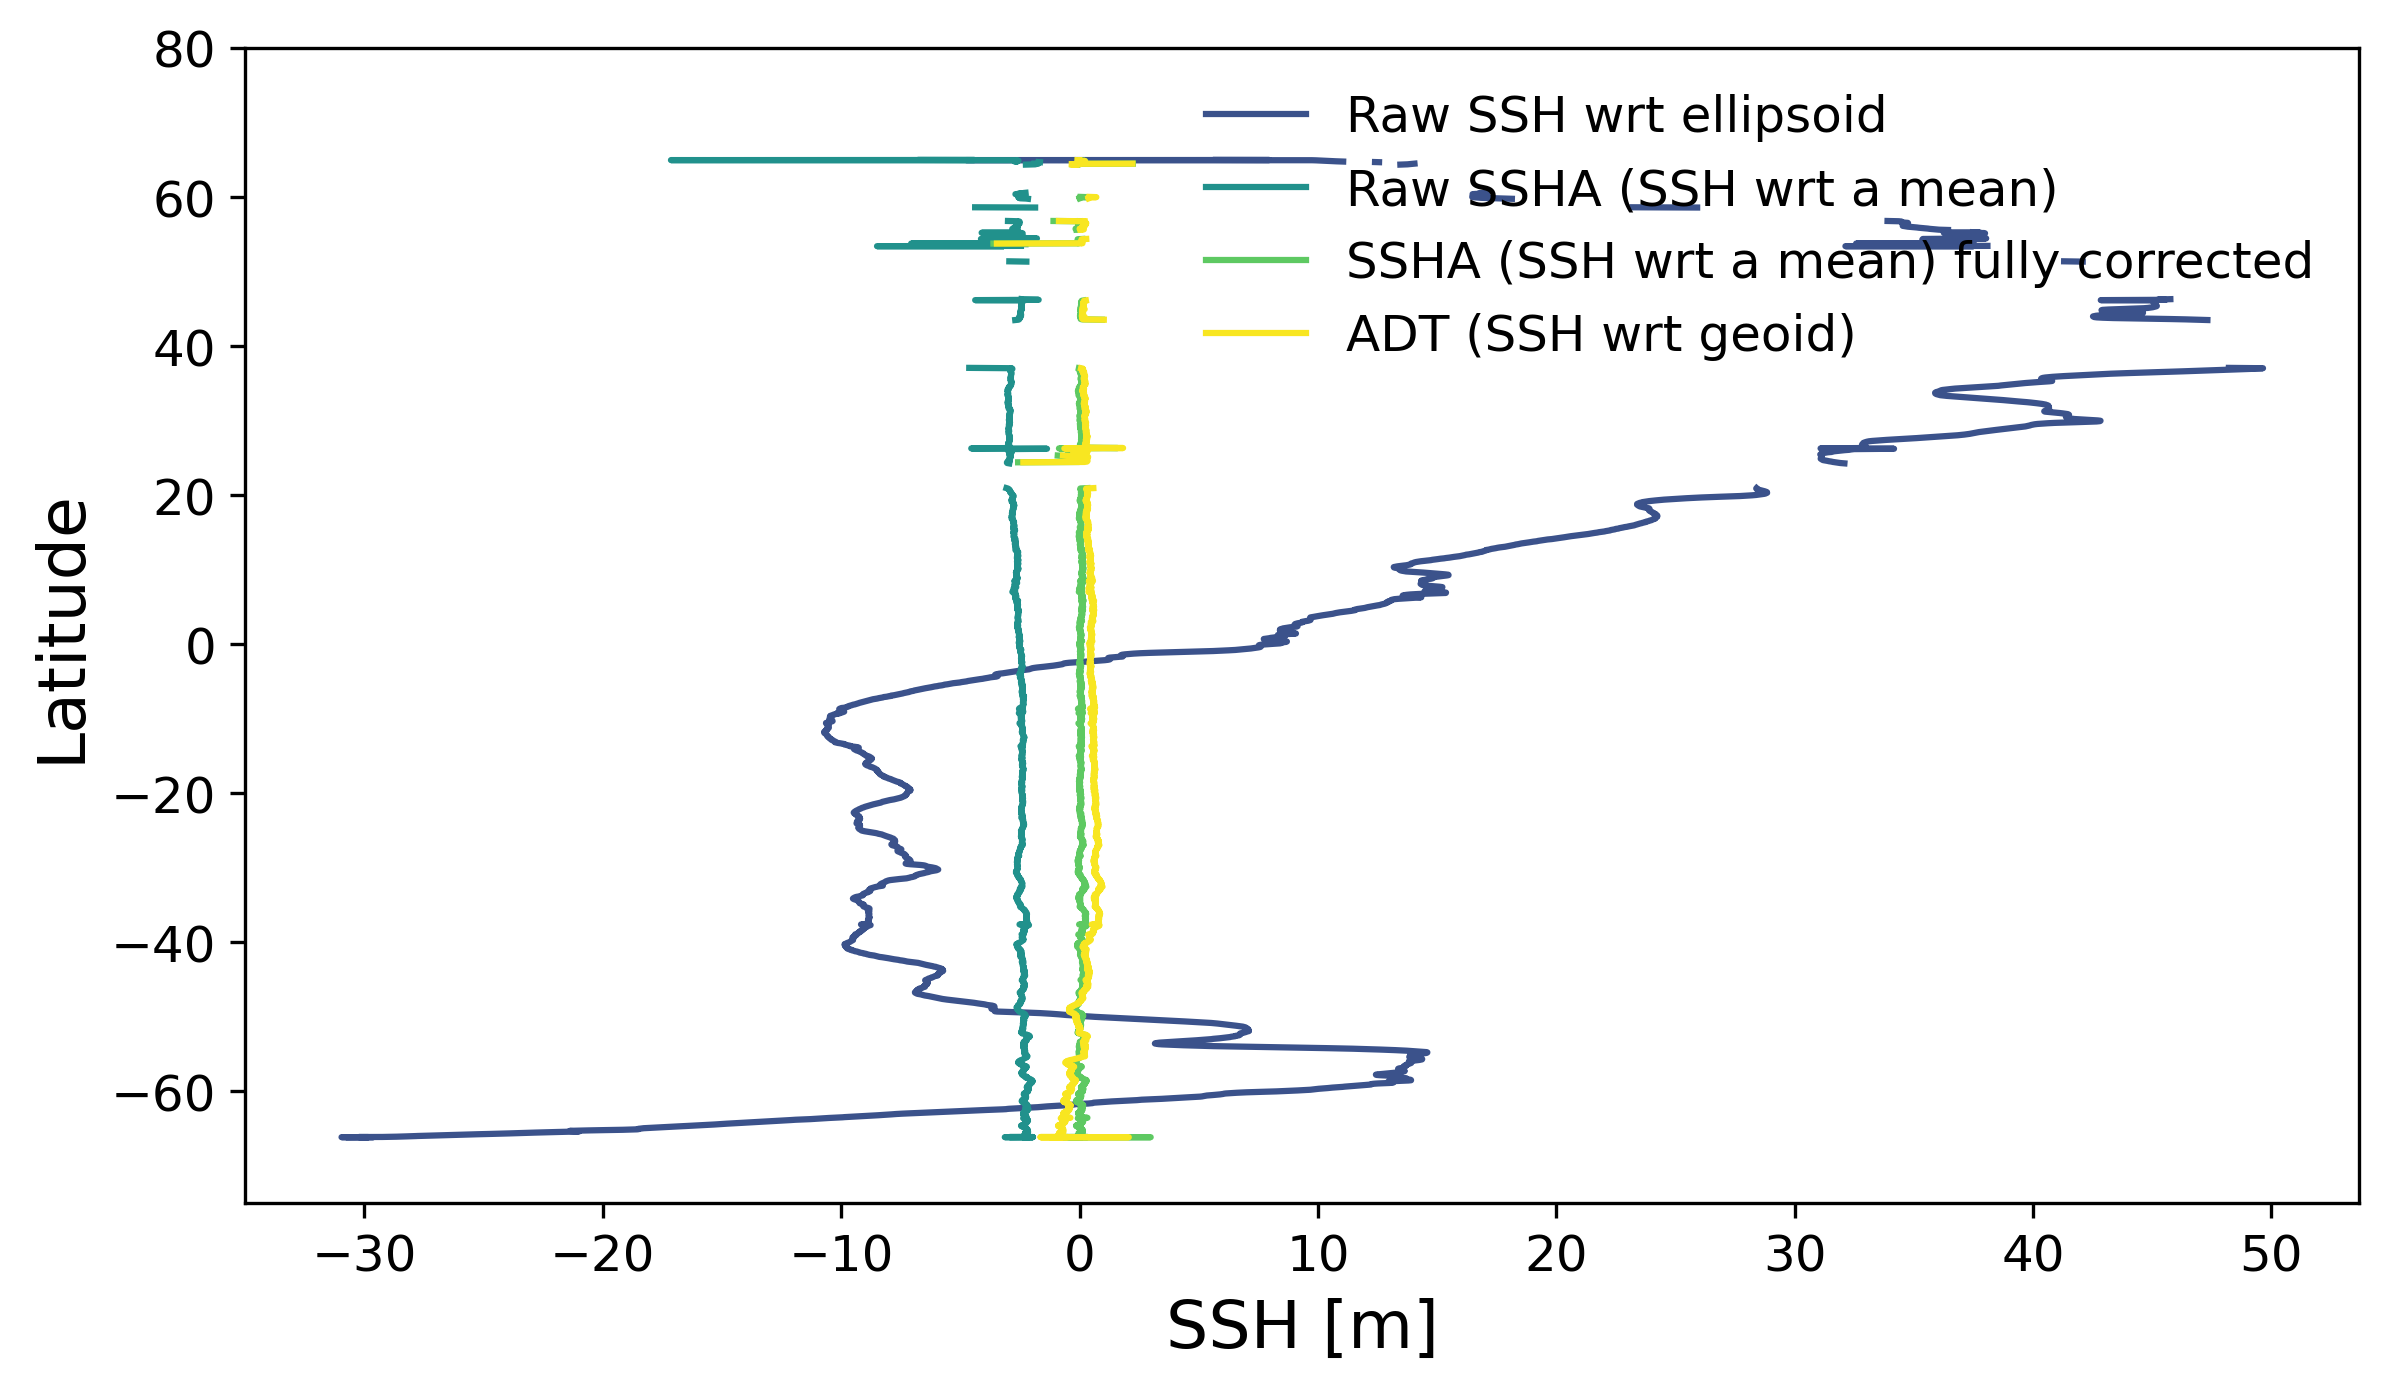

In [8]:
#plot e.g. a "raw" version of SSH (un-corrected) and the corrected ssha
fig1 = plt.figure(figsize=(20, 5), dpi=300)
ax = plt.subplot(1,2,1)
cmap = plt.cm.viridis
p1, = ax.plot(raw_ssh_ellipsoid, lat, c=cmap(0.25), label='Raw SSH wrt ellipsoid')
p2, = ax.plot(raw_ssha, lat, c=cmap(0.50), label='Raw SSHA (SSH wrt a mean)')
p3, = ax.plot(ssha_fullcorr, lat, c=cmap(0.75), label='SSHA (SSH wrt a mean) fully corrected')
p4, = ax.plot(adt, lat, c=cmap(0.99), label='ADT (SSH wrt geoid)')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, frameon=False)
ax.set_ylim([-75, 80])
ax.set_xlabel('SSH [m]', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
plt.show()

You can see that the corrected SSHA and ADT are different to the raw SSHA even if some features can be seen in both. Comparing this plot to the one above showing the corrections - which corrections do you think are contributing the most to the observed difference?

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Looking at SSHA in dynamic regions: the Drake Passage
[Back to top](#TOC_TOP)

</div>

The calculation of the sea surface height anomaly (SSHA) is done as part of the level-2 processing chain for Sentinel-6 altimetry products. Let's look at a couple of examples in an area where there the ocean is very physically dynamic: the Drake Passage.

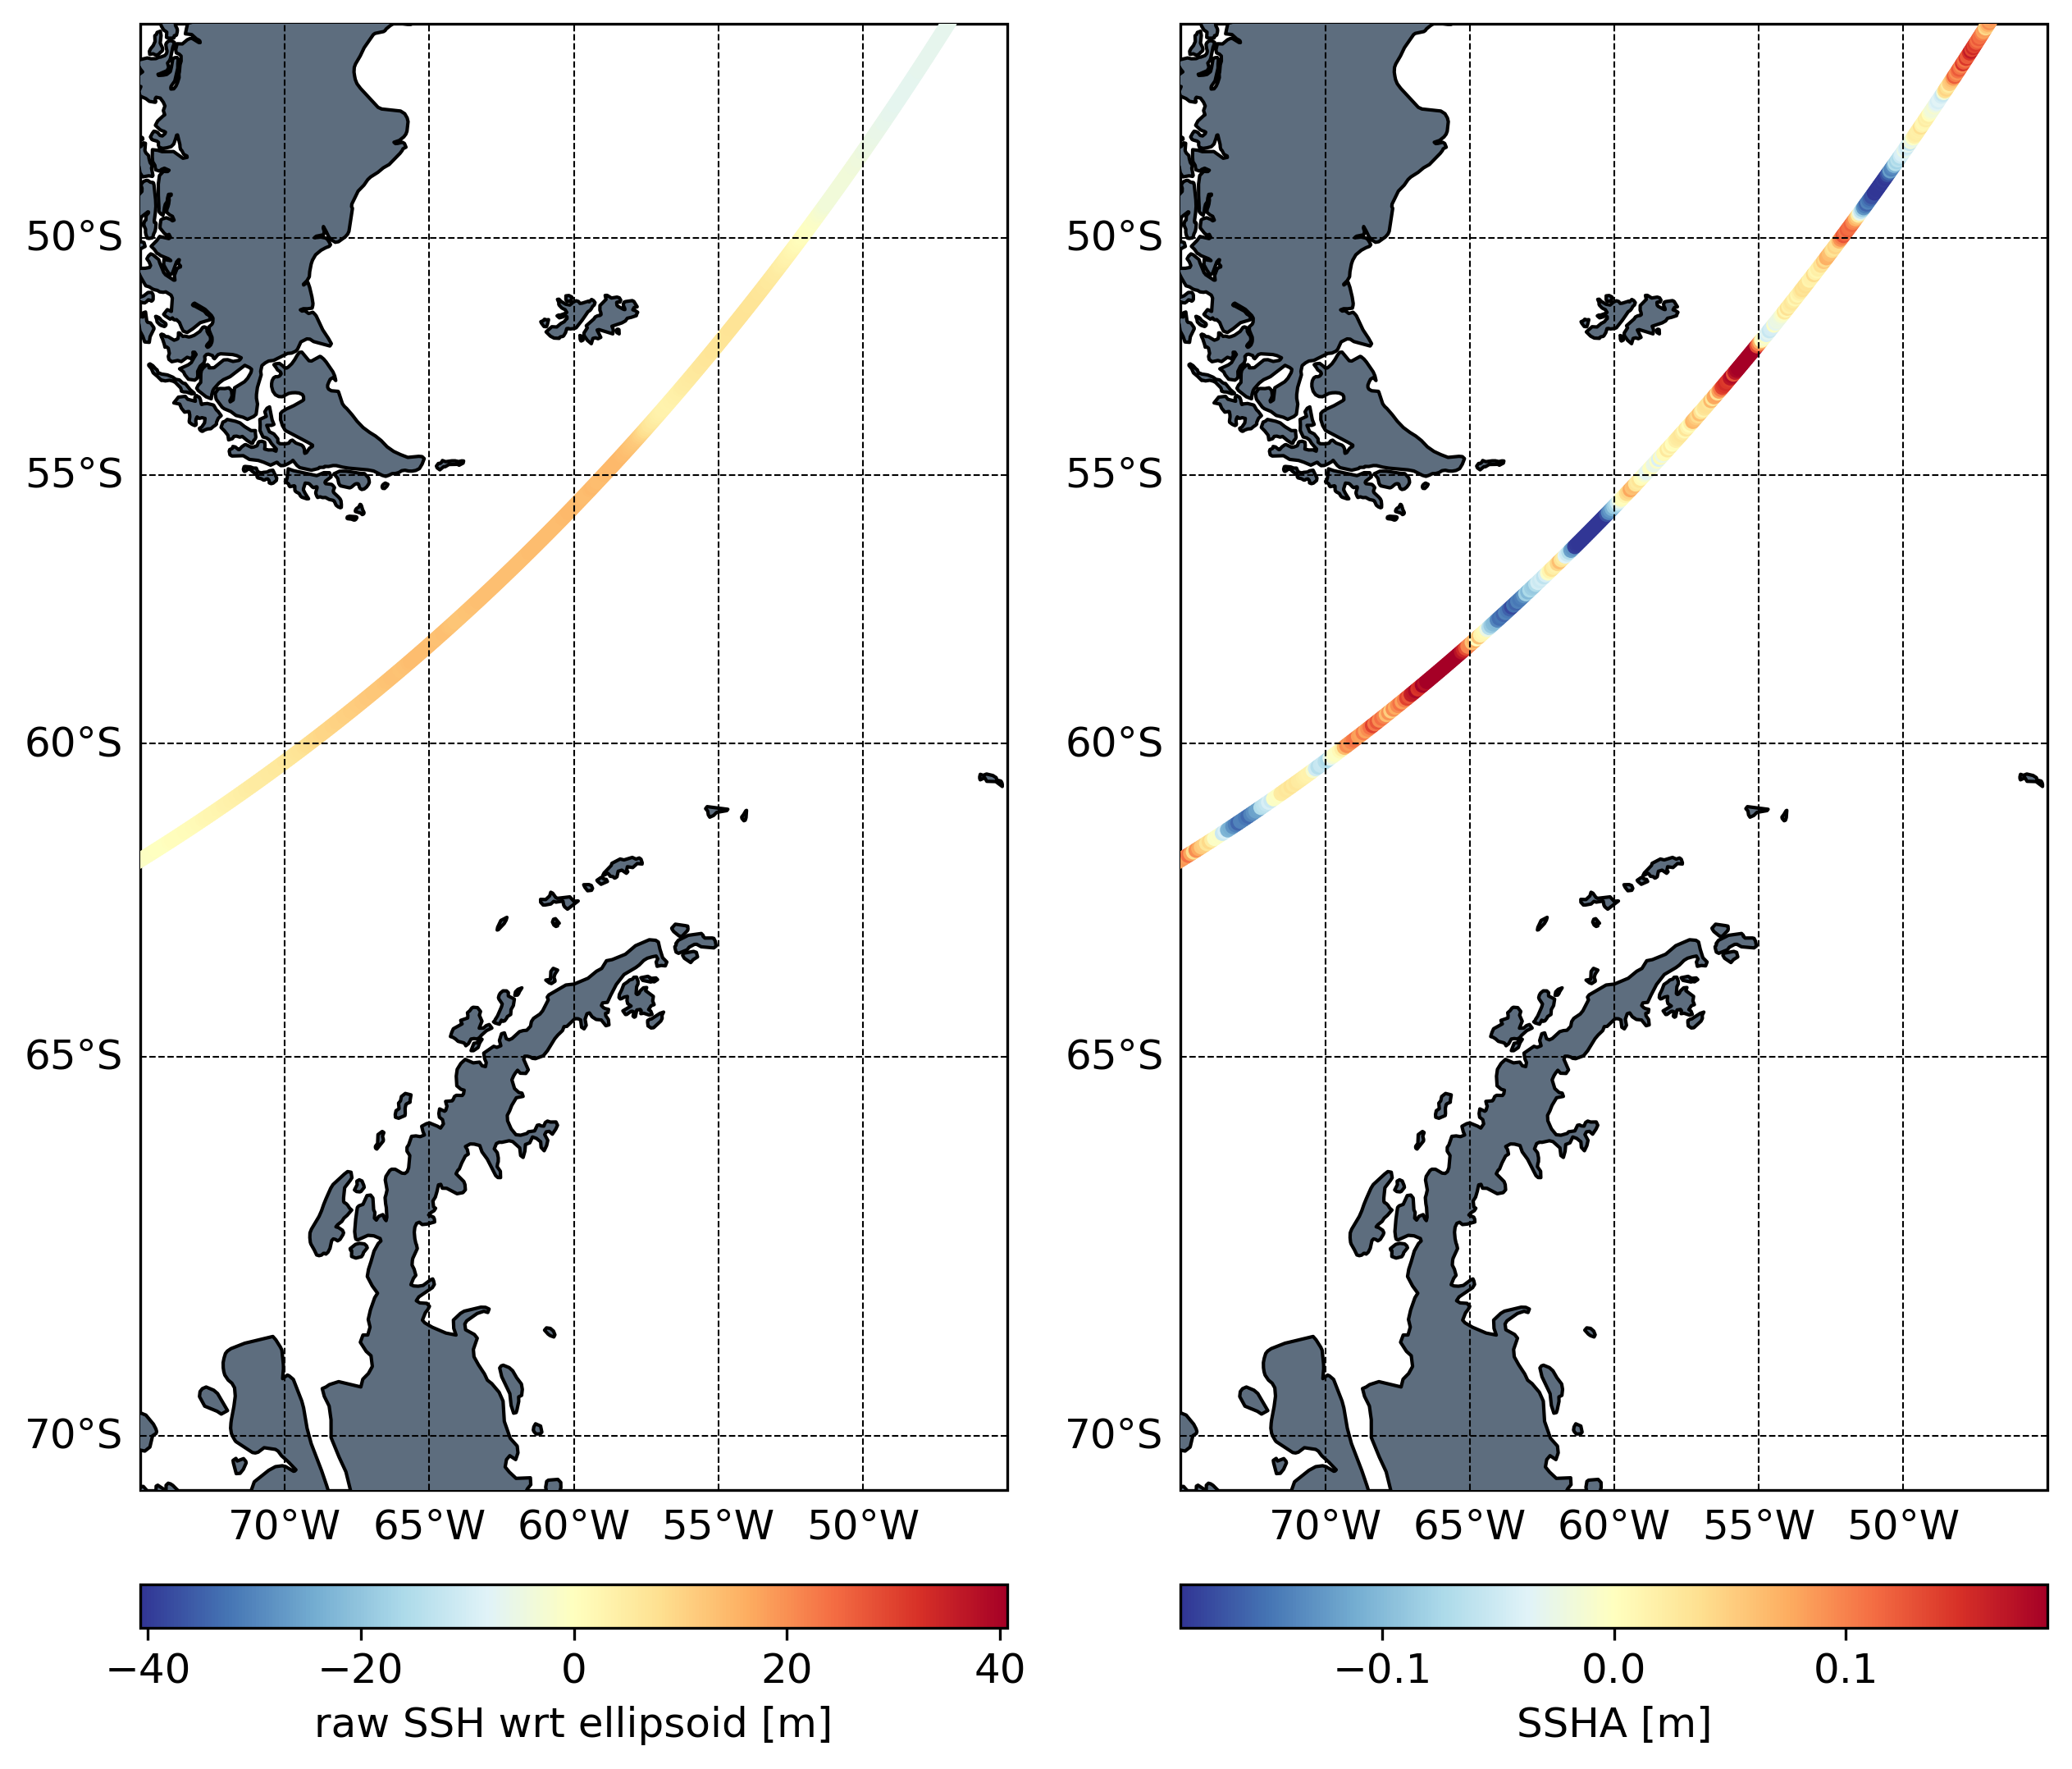

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": cartopy.crs.Mercator()})

cmap = plt.cm.RdYlBu_r

plot_vars = [raw_ssh_ellipsoid, ssha]

for ax, plot_var, label in zip(axs, plot_vars, ["raw SSH wrt ellipsoid [m]", "SSHA [m]"]):

    vmax = np.nanpercentile(np.abs(plot_var), 95)
    vmin = -1*vmax
    
    f1 = ax.plot(lon, lat, '0.5', zorder=2, linewidth=10)
        
    f1 = ax.scatter(lon, lat, c=plot_var, cmap=cmap, 
                   s=20, marker='o', edgecolors=None, linewidth=0.0, zorder=3, vmin=vmin, vmax=vmax, transform=cartopy.crs.PlateCarree())
    
    ax.add_feature(cartopy.feature.LAND, zorder=4, edgecolor='k', facecolor='#5D6D7E')
    g1 = ax.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--', linewidth=0.5)
    g1.top_labels = False
    g1.right_labels = False
    g1.xlabel_style = {'color': 'black'}
    g1.ylabel_style = {'color': 'black'}
    ax.set(facecolor = "1.0")
    ax.set_extent([-75, -45, -70, -45])       

    cbar = plt.colorbar(f1, ax=ax, orientation="horizontal", pad=0.05)
    cbar.set_label(label)

plt.savefig('1_6_S6_SSHA.png')

The Drake Passage shows very well how physical dynamics of the ocean can be captured using altimetry data. The postive and negative SSHA values are associated with the front systems and currents in the Southern Ocean can be seen in the figure above. 

<hr>
<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_5_S6_waveforms.ipynb"><< Sentinel-6 waveforms</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_7_S6_SWH.ipynb">Sentinel-6 significant wave height >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>